File              ML algorithm       accuracy        Precision       Recall          F1-score        Time           
all_data          Naive Bayes        0.54            0.51            0.52            0.47            39.1624        


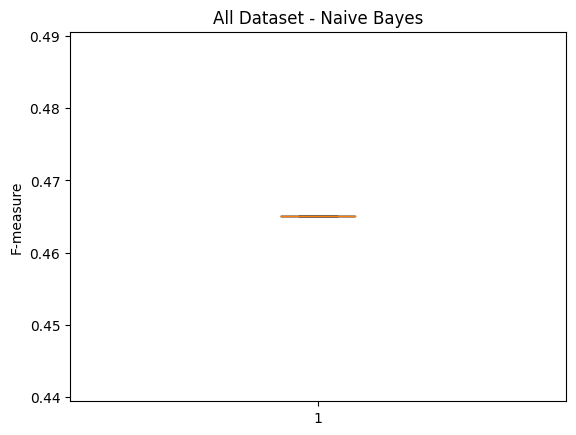

Execution time exceeded 5 minutes. Exiting loop.
all_data          QDA                0.52            0.61            0.69            0.5             39.902         


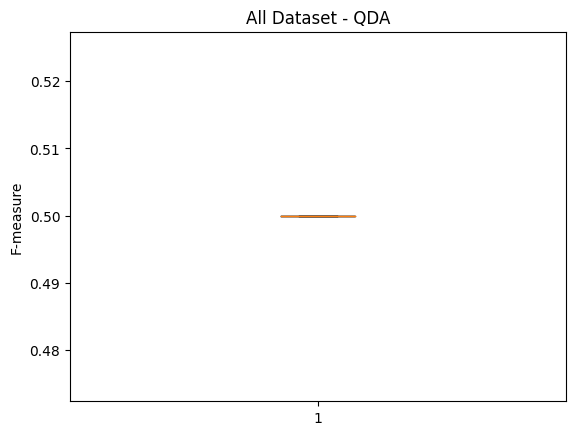

Execution time exceeded 5 minutes. Exiting loop.
all_data          Random Forest      0.89            0.8             0.89            0.83            54.0808        


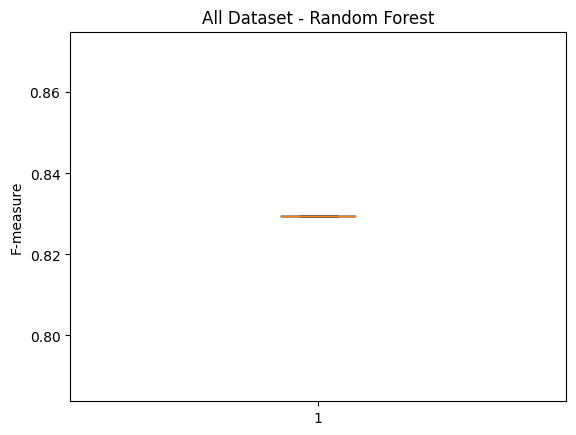

Execution time exceeded 5 minutes. Exiting loop.
all_data          ID3                0.9             0.82            0.92            0.85            47.7985        


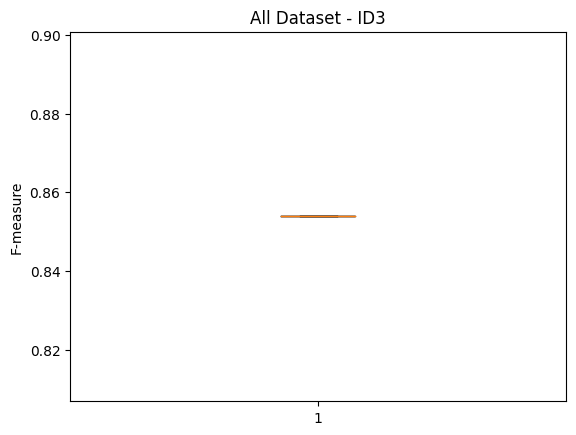

Execution time exceeded 5 minutes. Exiting loop.
all_data          AdaBoost           0.88            0.78            0.89            0.82            160.8209       


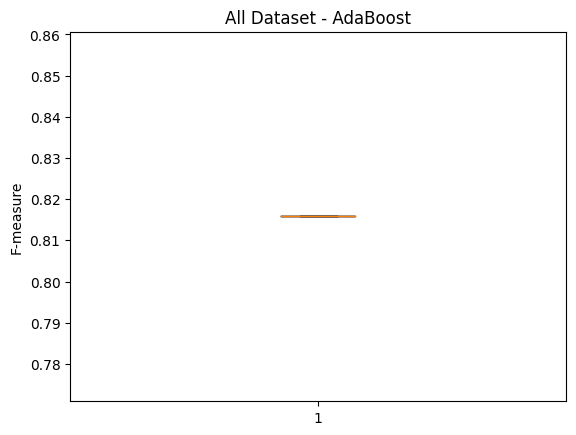

Execution time exceeded 5 minutes. Exiting loop.
all_data          XGBoost            0.96            0.91            0.96            0.94            108.23         


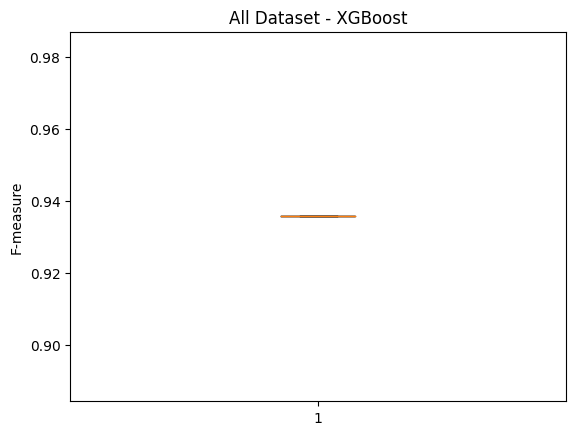

Execution time exceeded 5 minutes. Exiting loop.
all_data          Ensemble           0.97            0.93            0.96            0.95            508.4186       


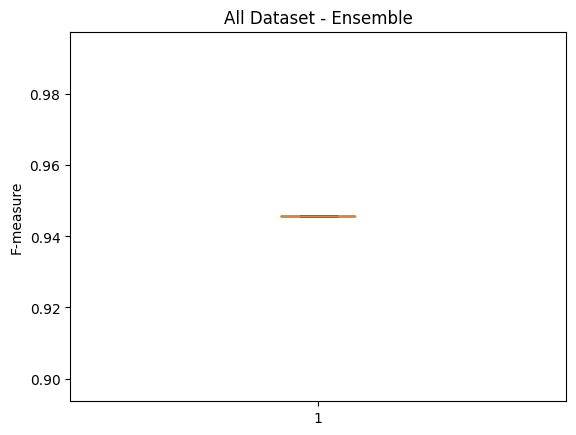

Execution time exceeded 5 minutes. Exiting loop.
mission accomplished!
Total operation time: =  1201.9456312656403 seconds


In [1]:
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, PowerTransformer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import csv
import time
import warnings

warnings.filterwarnings("ignore")

result = "./results/results_3.csv"  # CSV file to store the results
csv_files = ["all_data.csv"]  # Dataset files
path = ""  # Path to dataset files
repetition = 5  # Number of iterations for cross-validation

# Create folders for results and result graphs
def folder(f_name):
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print("The folder could not be created!")

folder_name = "./results/"
folder(folder_name)
folder_name = "./results/result_graph_3/"
folder(folder_name)

# Machine learning algorithms
ml_list = {
    "Naive Bayes": GaussianNB(),
    "QDA": QDA(),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "ID3": DecisionTreeClassifier(max_depth=5, criterion="entropy"),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(random_state=0)  # Adding XGBoost
}

# Define and add ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)),
    ('ada', AdaBoostClassifier()),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=0)),
    ('xgb', XGBClassifier(random_state=0))
], voting='soft')
ml_list["Ensemble"] = ensemble_model

# Selected features based on feature importance
features = {
    "all_data": [
        "Bwd Packet Length Std", "Flow Bytes/s", "Total Length of Fwd Packets", 
        "Fwd Packet Length Std", "Flow IAT Std", "Flow IAT Min", "Fwd IAT Total", "Label"
    ]
}

seconds = time.time()  # Timestamp for processing time

# Create CSV file to store results
with open(result, "w", newline="", encoding="utf-8") as f:
    wrt = csv.writer(f)
    wrt.writerow(["File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time"])

# Iterate through dataset files
for j in csv_files:
    print('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (
        "File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time"))

    feature_list = list(features[j[0:-4]])
    df = pd.read_csv(path + j, usecols=feature_list)
    df = df.fillna(0)

    # Convert label to binary (1 for BENIGN, 0 for attack)
    attack_or_not = [1 if i == "BENIGN" else 0 for i in df["Label"]]
    df["Label"] = attack_or_not

    y = df["Label"]
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    for ii in ml_list:
        precision = []
        recall = []
        f1 = []
        accuracy = []
        t_time = []

        for i in range(repetition):
            second = time.time()

            # Split data into train and test sets
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.20, random_state=repetition)

            # Feature scaling and transformation
            scaler = StandardScaler()
            pt = PowerTransformer()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            X_train = pt.fit_transform(X_train)
            X_test = pt.transform(X_test)

            # Apply SMOTE for imbalanced data
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)

            # Fit the model and predict
            clf = ml_list[ii]
            clf.fit(X_train, y_train)
            predict = clf.predict(X_test)

            # Calculate evaluation metrics
            f_1 = f1_score(y_test, predict, average='macro')
            pr = precision_score(y_test, predict, average='macro')
            rc = recall_score(y_test, predict, average='macro')

            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time() - second)))

            if time.time() - seconds >= 300:  # Check if 5 minutes (300 seconds) have passed
                print("Execution time exceeded 5 minutes. Exiting loop.")
                break

        # Print average results
        print('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (
            j[0:-4], ii, str(round(np.mean(accuracy), 2)), str(round(np.mean(precision), 2)),
            str(round(np.mean(recall), 2)), str(round(np.mean(f1), 2)), str(round(np.mean(t_time), 4))))

        # Write results to CSV
        with open(result, "a", newline="", encoding="utf-8") as f:
            wrt = csv.writer(f)
            for i in range(0, len(t_time)):
                wrt.writerow([j[0:-4], ii, accuracy[i], precision[i], recall[i], f1[i], t_time[i]])

        # Create box plots for F1-score
        plt.boxplot(f1)
        plt.title("All Dataset - " + str(ii))
        plt.ylabel('F-measure')
        plt.savefig(folder_name + j[0:-4] + str(ii) + ".pdf",
                    bbox_inches='tight', papertype='a4', orientation='portrait', format='pdf')
        plt.show()

    if time.time() - seconds >= 300:  # Check if 5 minutes (300 seconds) have passed
        print("Execution time exceeded 5 minutes. Exiting loop.")
        break

print("mission accomplished!")
print("Total operation time: = ", time.time() - seconds, "seconds")
